# Let's Import the Libraries to be used:

## 1. Let's download the libraries we'll be using

## 2. Let's import the libraries


In [21]:
import numpy as np
import  pandas as pd
import  seaborn as sns
import  scipy.stats as stats
import  matplotlib.pyplot as plt

import  plotly
import  plotly.graph_objs as go
import  plotly.io as pio
from plotly.subplots import make_subplots
import  plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import  cufflinks as cf
import  plotly.figure_factory as ff
from plotly.offline import iplot
from plotly import tools
from ipywidgets import widgets

from matplotlib.colors import to_rgba

plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.dpi'] = 100
colors = px.colors.qualitative.Prism
pio.templates.default = "plotly_white"

C:\Users\merte\AppData\Local\Temp\ipykernel_15908\3733042933.py:21: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



Libraries for data analysis:

In [22]:
from sklearn.model_selection import train_test_split
from feature_engine.imputation import CategoricalImputer
from feature_engine import transformation as vt
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder
from feature_engine.imputation import AddMissingIndicator
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [23]:
target_variable_names=["yield_strength",
"ultimate_tensile_strength",]

In [24]:
X_train=pd.read_csv('data/train.csv',)
y_train=X_train[target_variable_names]
X_train.drop(columns=target_variable_names + ["Unnamed: 0"], inplace=True)


X_valid=pd.read_csv('data/validation.csv')
y_valid=X_valid[target_variable_names]
X_valid.drop(columns=target_variable_names + ["Unnamed: 0"],inplace=True)


X_test=pd.read_csv('data/test.csv')
y_test=X_test[target_variable_names]
X_test.drop(columns=target_variable_names + ["Unnamed: 0"],inplace=True)


In [25]:
X_train

,carbon_concentration_per_weight,silicon_concentration_per_weight,manganese_concentration_per_weight,sulphur_concentration_per_weight,phosphorus_concentration_per_weight,nickel_concentration_per_weight,hromium_concentration_per_weight,olybdenum_concentration_per_weight,anadium_concentration_per_weight,copper_concentration_per_weight,...,charpy_temperature,charpy_impact_toughness,hardness,50_FATT,primary_ferrite_in_microstructure,ferrite_with_second_phase,acicular_ferrite,martensite,ferrite_with_carbide_aggreagate,weld_id
0,0.075,0.35,0.80,0.020,0.017,NaN,2.300,1.50,NaN,NaN,...,NaN,NaN,220.0,NaN,NaN,NaN,NaN,NaN,NaN,Wolst-1974
1,0.076,0.25,1.45,0.008,0.006,0.00,0.000,0.50,0.0005,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EvansLetterC
2,0.072,0.34,1.33,0.006,0.008,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18.0,15.0,67.0,0.0,0.0,Evans-AlTi-1994
3,0.110,0.36,2.18,0.008,0.011,NaN,NaN,NaN,NaN,NaN,...,-40.0,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SvenGret-1990
4,0.080,0.28,1.48,0.007,0.006,0.00,1.070,0.00,0.0005,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EvansLetterC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,0.060,0.20,1.15,0.007,0.017,0.16,0.052,0.45,NaN,0.128,...,-10.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blond&-1984
1152,0.080,0.59,1.84,0.013,0.016,0.01,0.050,0.01,0.0100,0.380,...,9.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kluket-CuMnB-1994
1153,0.043,0.24,1.37,0.008,0.013,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EvHtIp1979
1154,0.078,0.30,1.76,0.007,0.007,NaN,NaN,NaN,0.0004,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Nb/Mn-1991


# Data Preprocessing

Let's first separate categorical and numerical variables:

In [26]:
def get_categorical_variables(df):
    return df.select_dtypes(include='object').columns

def get_numerical_variables(df):
    return df.select_dtypes(exclude='object').columns

In [27]:
categorical_features=get_categorical_variables(X_train).tolist()
numeric_features=get_numerical_variables(X_train).tolist()

## Categorical Features - Missing or Wrong Label

Let's start doing the data imputation on these variables. For this type of variable, we'll add the new "Missing" category, so that the model can capture the reason for the missing instance (if it exists).

In [28]:
categorical_imputer = CategoricalImputer()

# fit the imputer
categorical_imputer.fit(X_train)

# transform the data
X_train= categorical_imputer.transform(X_train)
X_valid= categorical_imputer.transform(X_valid)
X_test= categorical_imputer.transform(X_test)

Let's check the new distribution of some categorical variables that had missing data:

In [29]:
def verify_pct_of_categories(X_train,feature_names):
  total_samples=len(X_train)
  for feature in feature_names:
    temp_df=pd.Series(X_train[feature].value_counts()/total_samples)
    fig=temp_df.sort_values(ascending=False).plot.bar(color="#FFE680")
    fig.axhline(y=0.05,color='red')
    fig.set_ylabel(f'Percentual of {feature}')
    plt.show()

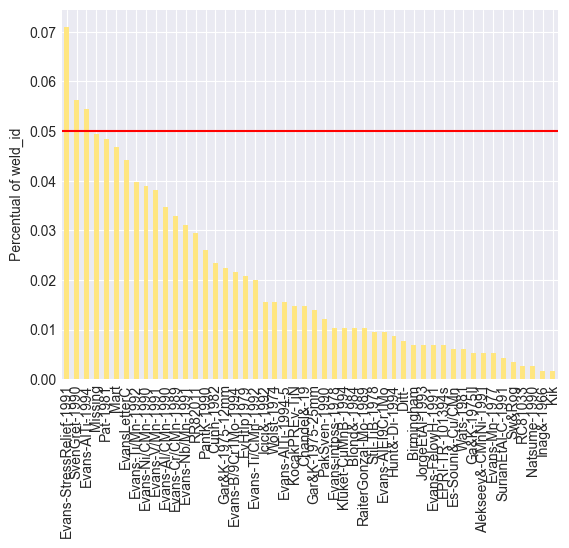

In [30]:
verify_pct_of_categories(X_train,['weld_id'])


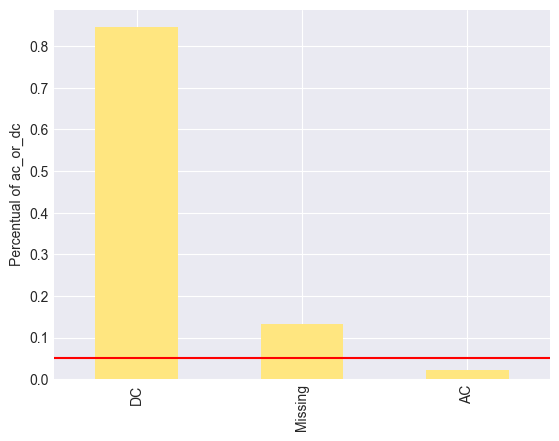

In [31]:
verify_pct_of_categories(X_train,['ac_or_dc'])


## Categorical Encoding


Having added the "Missing" category to the dataset, performing categorical imputation, we are now going to use DecisionTreeEncoder to try to capture a monotonic relationship between the categories and the target.

In [12]:
# Not working
""" import pandas as pd
from feature_engine.encoding import DecisionTreeEncoder

X_train_non_null = X_train[y_train["Yield strength / MPa"].notnull()]
y_train_non_null = y_train[y_train["Yield strength / MPa"].notnull()]["Yield strength / MPa"]

woe_encoder = DecisionTreeEncoder(cv=2)

woe_encoder.fit(X_train_non_null, y_train_non_null)

X_train_encoded = woe_encoder.transform(X_train)
X_valid_encoded = woe_encoder.transform(X_valid)
X_test_encoded = woe_encoder.transform(X_test)"""

' import pandas as pd\nfrom feature_engine.encoding import DecisionTreeEncoder\n\nX_train_non_null = X_train[y_train["Yield strength / MPa"].notnull()]\ny_train_non_null = y_train[y_train["Yield strength / MPa"].notnull()]["Yield strength / MPa"]\n\nwoe_encoder = DecisionTreeEncoder(cv=2)\n\nwoe_encoder.fit(X_train_non_null, y_train_non_null)\n\nX_train_encoded = woe_encoder.transform(X_train)\nX_valid_encoded = woe_encoder.transform(X_valid)\nX_test_encoded = woe_encoder.transform(X_test)'

In [32]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import umap

def one_hot_encode_and_reduce_multiple(X_train, X_val, X_test, n_components=2, random_state=42):


    categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
    
    # Inicializar o OneHotEncoder
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    # Ajustar o encoder nos dados de treino e transformar
    encoded_train = encoder.fit_transform(X_train[categorical_columns])
    encoded_val = encoder.transform(X_val[categorical_columns])
    encoded_test = encoder.transform(X_test[categorical_columns])
    
    # Nomear as colunas do one-hot encoding
    encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_val_df = pd.DataFrame(encoded_val, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_columns))
    
    # Aplicar UMAP apenas nas colunas geradas pelo one-hot encoding
    reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    
    # Ajustar nos dados de treino e transformar também validação e teste
    reduced_train = reducer.fit_transform(encoded_train_df)
    reduced_val = reducer.transform(encoded_val_df)
    reduced_test = reducer.transform(encoded_test_df)
    
    # Retornar DataFrames com a dimensionalidade reduzida
    reduced_train_df = pd.DataFrame(reduced_train, columns=[f'UMAP_{i+1}' for i in range(n_components)])
    reduced_val_df = pd.DataFrame(reduced_val, columns=[f'UMAP_{i+1}' for i in range(n_components)])
    reduced_test_df = pd.DataFrame(reduced_test, columns=[f'UMAP_{i+1}' for i in range(n_components)])
    
    # Combinar as colunas numéricas originais com os resultados do UMAP
    X_train_numeric = X_train.drop(columns=categorical_columns).reset_index(drop=True)
    X_val_numeric = X_val.drop(columns=categorical_columns).reset_index(drop=True)
    X_test_numeric = X_test.drop(columns=categorical_columns).reset_index(drop=True)
    
    final_train = pd.concat([X_train_numeric, reduced_train_df], axis=1)
    final_val = pd.concat([X_val_numeric, reduced_val_df], axis=1)
    final_test = pd.concat([X_test_numeric, reduced_test_df], axis=1)
    
    return final_train, final_val, final_test


In [33]:
X_train, X_valid, X_test = one_hot_encode_and_reduce_multiple(X_train, X_valid, X_test, n_components=7)

c:\Users\merte\miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

c:\Users\merte\miniconda3\lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## Dealing with NaN

We will use the reference paper in the dataset to extract some tips to deal with the missing values

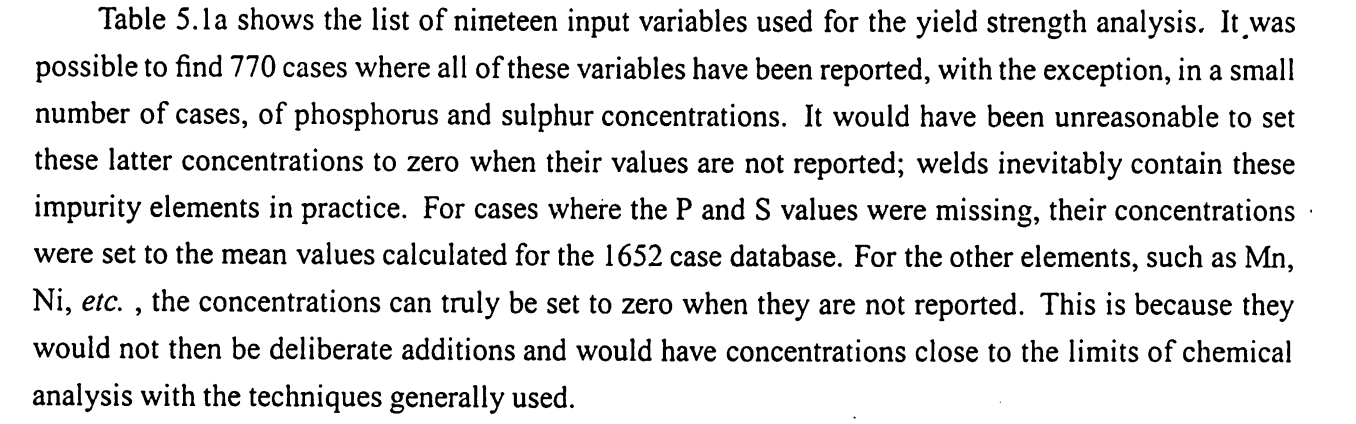

So, phosphorus and sulphur, we will imput with the mean, or other more advanced techniques
Other elements, such as Mn, Ni, it would be zero.
We now need to find what to do with the others based on these elementes

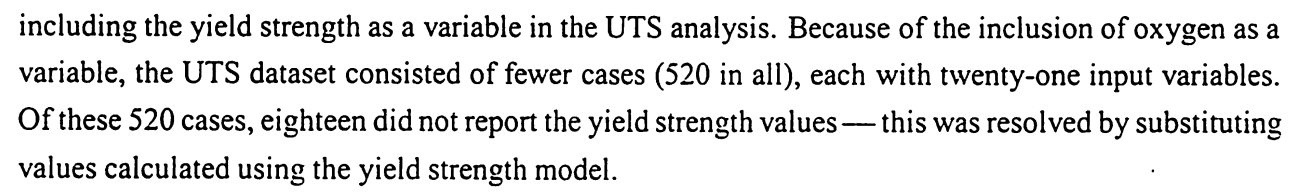

We need also take into account if the missing values are MAR, MCAR or MNAR, and for each type we need to use a different startegy

Other thing we are gonna look is if the fact of the data is missing is a valuable information

First of all, let's create the functions to do some data inputation

In [34]:
columns_to_drop = ["hardness",
"50_FATT",
"primary_ferrite_in_microstructure",
"ferrite_with_second_phase",
"acicular_ferrite",
"martensite",
"ferrite_with_carbide_aggreagate",]

X_train.drop(columns=columns_to_drop, inplace=True)
X_valid.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

In [35]:
numeric_features=get_numerical_variables(X_train).tolist()

In [36]:
def create_missing_value_column(df, columns, name='tem_nan'):
    df[name] = df[columns].isna().any(axis=1).astype(int)
    return df


group_1 = [ "carbon_concentration_per_weight", "silicon_concentration_per_weight",
            "manganese_concentration_per_weight", "sulphur_concentration_per_weight",
"phosphorus_concentration_per_weight"]

group_2 = ["nickel_concentration_per_weight", "hromium_concentration_per_weight", "olybdenum_concentration_per_weight",
"anadium_concentration_per_weight","copper_concentration_per_weight"
        ]

group_3 = ["cobalt_concentration_per_weight","tungsten_concentration_per_weight"]

group_4 = ["oxygen_concentration_per_parts_per_million_by_weight",
"titanium_concentration_per_parts_per_million_by_weight",
"nitrogen_concentration_per_parts_per_million_by_weight",
"aluminium_concentration_per_parts_per_million_by_weight",
"boron_concentration_per_parts_per_million_by_weight",
"niobium_concentration_per_parts_per_million_by_weight"
        ]

group_5 = ["tin_concentration_per_parts_per_million_by_weight",
"arsenic_concentration_per_parts_per_million_by_weight",
"antimony_concentration_per_parts_per_million_by_weight",]


X_train = create_missing_value_column(X_train, group_1, "group_1")
X_valid = create_missing_value_column(X_valid, group_1, "group_1")
X_test = create_missing_value_column(X_test, group_1, "group_1")

X_train = create_missing_value_column(X_train, group_2, "group_2")
X_valid = create_missing_value_column(X_valid, group_2, "group_2")
X_test = create_missing_value_column(X_test, group_2, "group_2")

X_train = create_missing_value_column(X_train, group_3, "group_3")
X_valid = create_missing_value_column(X_valid, group_3, "group_3")
X_test = create_missing_value_column(X_test, group_3, "group_3")

X_train = create_missing_value_column(X_train, group_4, "group_4")
X_valid = create_missing_value_column(X_valid, group_4, "group_4")
X_test = create_missing_value_column(X_test, group_4, "group_4")

X_train = create_missing_value_column(X_train, group_5, "group_5")
X_valid = create_missing_value_column(X_valid, group_5, "group_5")
X_test = create_missing_value_column(X_test, group_5, "group_5")

In [38]:
def impute_constant(X_train, X_val, X_test, constant_value, columns=None):
    imputer = SimpleImputer(strategy='constant', fill_value=constant_value)
    if columns is None:
        columns = X_train.columns
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()
    
    X_train_imputed[columns] = imputer.fit_transform(X_train[columns])
    X_val_imputed[columns] = imputer.transform(X_val[columns])
    X_test_imputed[columns] = imputer.transform(X_test[columns])
    
    return X_train_imputed, X_val_imputed, X_test_imputed

def impute_mean(X_train, X_val, X_test, columns=None):
    imputer = SimpleImputer(strategy='mean')
    if columns is None:
        columns = X_train.columns
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()
    
    X_train_imputed[columns] = imputer.fit_transform(X_train[columns])
    X_val_imputed[columns] = imputer.transform(X_val[columns])
    X_test_imputed[columns] = imputer.transform(X_test[columns])
    
    return X_train_imputed, X_val_imputed, X_test_imputed

def impute_median(X_train, X_val, X_test, columns=None):
    imputer = SimpleImputer(strategy='median')
    if columns is None:
        columns = X_train.columns
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()
    
    X_train_imputed[columns] = imputer.fit_transform(X_train[columns])
    X_val_imputed[columns] = imputer.transform(X_val[columns])
    X_test_imputed[columns] = imputer.transform(X_test[columns])
    
    return X_train_imputed, X_val_imputed, X_test_imputed


def impute_mode(X_train, X_val, X_test, columns=None):
    imputer = SimpleImputer(strategy='most_frequent')
    if columns is None:
        columns = X_train.columns
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()
    
    X_train_imputed[columns] = imputer.fit_transform(X_train[columns])
    X_val_imputed[columns] = imputer.transform(X_val[columns])
    X_test_imputed[columns] = imputer.transform(X_test[columns])
    
    return X_train_imputed, X_val_imputed, X_test_imputed


def impute_multiple(X_train, X_val, X_test, columns=None):
    imputer = IterativeImputer()
    if columns is None:
        columns = X_train.columns
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()
    
    X_train_imputed[columns] = imputer.fit_transform(X_train[columns])
    X_val_imputed[columns] = imputer.transform(X_val[columns])
    X_test_imputed[columns] = imputer.transform(X_test[columns])
    
    return X_train_imputed, X_val_imputed, X_test_imputed



def impute_knn(X_train, X_val, X_test, columns=None):
    imputer = KNNImputer(n_neighbors=3)
    if columns is None:
        columns = X_train.columns
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()
    
    X_train_imputed[columns] = imputer.fit_transform(X_train[columns])
    X_val_imputed[columns] = imputer.transform(X_val[columns])
    X_test_imputed[columns] = imputer.transform(X_test[columns])
    
    return X_train_imputed, X_val_imputed, X_test_imputed


def impute_random_forest(X_train, X_val, X_test, target_column, features=None):
    if features is None:
        features = X_train.columns[X_train.columns != target_column]
    
    X_train_non_null = X_train[X_train[target_column].notnull()]
    X_train_null = X_train[X_train[target_column].isnull()]

    model = RandomForestRegressor()
    model.fit(X_train_non_null[features], X_train_non_null[target_column])

    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    X_test_imputed = X_test.copy()

    X_train_imputed.loc[X_train_imputed[target_column].isnull(), target_column] = model.predict(X_train_null[features])
    X_val_imputed[target_column] = model.predict(X_val[features])
    X_test_imputed[target_column] = model.predict(X_test[features])
    
    return X_train_imputed, X_val_imputed, X_test_imputed


def impute_data(X_train, X_val, X_test, method, *args, **kwargs):
    if method == 'constant':
        return impute_constant(X_train, X_val, X_test, *args, **kwargs)
    elif method == 'mean':
        return impute_mean(X_train, X_val, X_test, *args, **kwargs)
    elif method == 'median':
        return impute_median(X_train, X_val, X_test, *args, **kwargs)
    elif method == 'mode':
        return impute_mode(X_train, X_val, X_test, *args, **kwargs)
    elif method == 'multiple':
        return impute_multiple(X_train, X_val, X_test, *args, **kwargs)
    elif method == 'knn':
        return impute_knn(X_train, X_val, X_test, *args, **kwargs)
    elif method == 'rf':
        return impute_random_forest(X_train, X_val, X_test, *args, **kwargs)
    else:
        raise ValueError(f"Method '{method}' is not recognized.")

In [39]:
X_train_constant, X_valid_constant, X_test_constant  = impute_data(X_train, X_valid, X_test, 'constant', 0, numeric_features)
X_train_mean, X_valid_mean, X_test_mean = impute_data(X_train, X_valid, X_test, 'mean', numeric_features)

X_train_median, X_valid_median, X_test_median = impute_data(X_train, X_valid, X_test, 'median', numeric_features)
X_train_mode, X_valid_mode, X_test_mode = impute_data(X_train, X_valid, X_test, 'mode', numeric_features)
X_train_multiple, X_valid_multiple, X_test_multiple = impute_data(X_train, X_valid, X_test, 'multiple', numeric_features)
X_train_knn, X_valid_knn, X_test_knn = impute_data(X_train, X_valid, X_test, 'knn', numeric_features)

MCAR -> mean, constant
MAR ->
MNAR ->

Our ideal strategy:

the last columns we will delete

the first columns we will check if we are gonna replace with zero, mean, or KNN.

we will create a column related to the missing values of some groups of columns

Do one hot encoding in the categorical features, and after that PCA on everything related to the categorical features


## Transformation of Variables

Let's try to make the variables more symmetrically distributed (which helps in training the models). Let's check some transformations:

In [82]:
def view_tranformations(X_train,columns_names,transformation_name='YeoJohnson'):

  df_before = pd.DataFrame({'Skew':[X_train[feature].skew() for feature in columns_names],
                              'Feature':[feature for feature in columns_names]})

  if transformation_name in ['log','Log','LOG','ln','logaritmo natural']:
    tf = vt.LogTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                             'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Log-Transformation'
  elif transformation_name in ['boxcox','Boxcox','box cox','box-cox','Box-cox','Box cox']:
    tf = vt.BoxCoxTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Boxcox-Transformation'
  elif transformation_name in ['YeoJohnson','Yeo Johnson','Yeo-Johnson','yeojohnson','yeo johnson','yeo-johnson']:
    tf = vt.YeoJohnsonTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after YeoJohnson-Transformation'
  elif transformation_name in ['Reciprocal','Inverse','reciprocal','inverse','inverso','reciproco']:
    tf = vt.ReciprocalTransformer(variables = columns_names)
    tf.fit(X_train)
    X_tf=tf.transform(X_train)
    df_after = pd.DataFrame({'Skew':[X_tf[feature].skew() for feature in columns_names],
                                'Feature':[feature for feature in columns_names]})
    label='Skewness before and after Reciprocal-Transformation'
  else:
    raise Exception('\nColoque uma das transformações válidas:\nLog\nBox-Cox\nYeo-Johnson\nReciprocal')


  f, ax = plt.subplots(figsize=(6, 6))
  sns.set_color_codes("muted")
  sns.set_style('darkgrid')
  sns.barplot(x="Skew", y="Feature", data=df_before,
              label="Before", alpha=0.5)

  sns.set_color_codes("muted")
  sns.barplot(x="Skew", y="Feature", data=df_after,
              label="After",alpha=1)

  ax.legend(ncol=2, loc="best", frameon=True)
  ax.set(ylabel="",
        xlabel=label)
  sns.despine(left=True, bottom=True)
  plt.grid()
  plt.show()

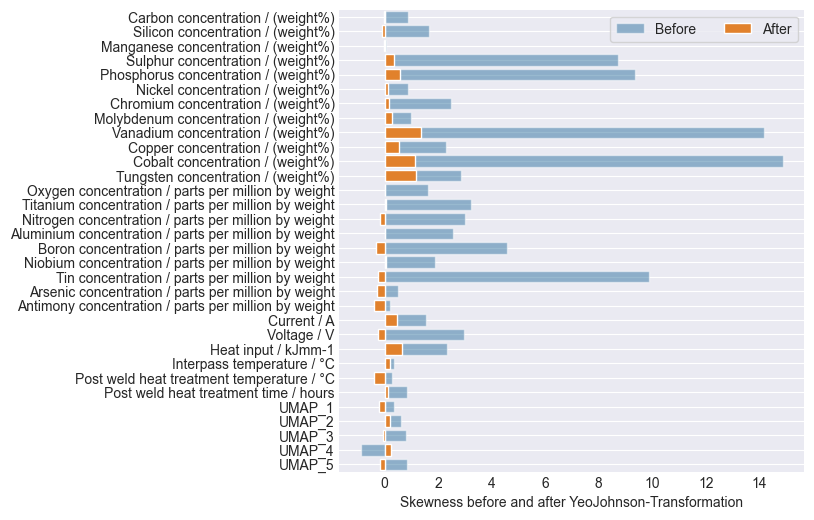

In [83]:
view_tranformations(X_train_knn, numeric_features)

In [84]:
yeojohnson_transform=vt.YeoJohnsonTransformer(variables=numeric_features)

yeojohnson_transform.fit(X_train_knn)

X_train_knn=yeojohnson_transform.transform(X_train_knn)
X_valid_knn=yeojohnson_transform.transform(X_valid_knn)
X_test_knn=yeojohnson_transform.transform(X_test_knn)

In [85]:
def diagnostic_plots(df,variable,lib):
  if lib=='plotly' or lib=='Plotly':
    fig=make_subplots(rows=1, cols=3,subplot_titles=('Histograma','Gráfico QQ','Box-Plot'))
    #Vamos plotar o Histograma
    fig_hist=ff.create_distplot([df[variable].values], [variable])
    fig.add_trace(go.Histogram(fig_hist['data'][0],
                              marker_color='#FFCC00',
                              ), row=1, col=1)

    fig.add_trace(go.Scatter(fig_hist['data'][1],
                         line=dict(color='#FF851B')
                        ), row=1, col=1)
    #Vamos plotar o gráfico QQ
    qq = stats.probplot(df[variable], dist='norm', sparams=(1))
    x = np.array([qq[0][0][0], qq[0][0][-1]])
    qq_df=pd.DataFrame({'x':np.array(qq[0][0].tolist()),
                    'y':np.array(qq[0][1].tolist()),
                    'index':df.index.tolist()},index=None)
    fig_qq=go.Scatter(x=qq_df['x'],
                            y=qq_df['y'],
                            mode='markers',
                            name=variable,
                            text=qq_df['index'],
                            marker_color='rgba(31, 150, 139, 0.9)')

    fig_qq.update(mode='markers', marker_line_width=0.15, marker_size=5)
    fig.append_trace(fig_qq, row=1, col=2)
    fig.append_trace(go.Scatter(x=x,
                                y=qq[1][1] + qq[1][0]*x,
                                mode='lines',
                                name='Normal',
                                marker_color='rgba(255, 90, 0, 0.9)'), row=1, col=2)
    fig.layout.update(title='Resumo da Variável '+ variable)
    #Vamos o gráfico Box-Plot
    fig_box=go.Box(y=df[variable],
                  boxpoints='all',
                  jitter=0.4, # add some jitter for a better separation between points
                  boxmean='sd',
                  text=df.index.tolist(),
                  name='Box-Plot',
                  marker_color='#FFCC00',
                  line_color='#FF851B')
    fig.append_trace(fig_box, row=1, col=3)
    fig.show()

  elif lib=='matplotlib' or lib=='pyplot':
    #function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x=variable, kde=True,color='#E0B100',stat="density")
    plt.title('Histogram')

    # Q-Q plot
    ax=plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    ax.get_lines()[0].set_markersize(7.0)
    ax.get_lines()[0].set_markerfacecolor('#44B1A5')
    ax.get_lines()[0].set_color('#44B1A5')

    ax.get_lines()[1].set_markerfacecolor('#FF7627')
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=variable, data=df,color='#FFCC00',linewidth=2.5)
    sns.swarmplot(y=variable, data=df.iloc[0:300], color="#FFE680")
    plt.title('Boxplot')

    plt.suptitle('Distribuição de '+ variable, fontsize=16)
    plt.show()

  else:
    print('Escolha como library (argumento lib) ou "matplotlib" ou "plotly"!')


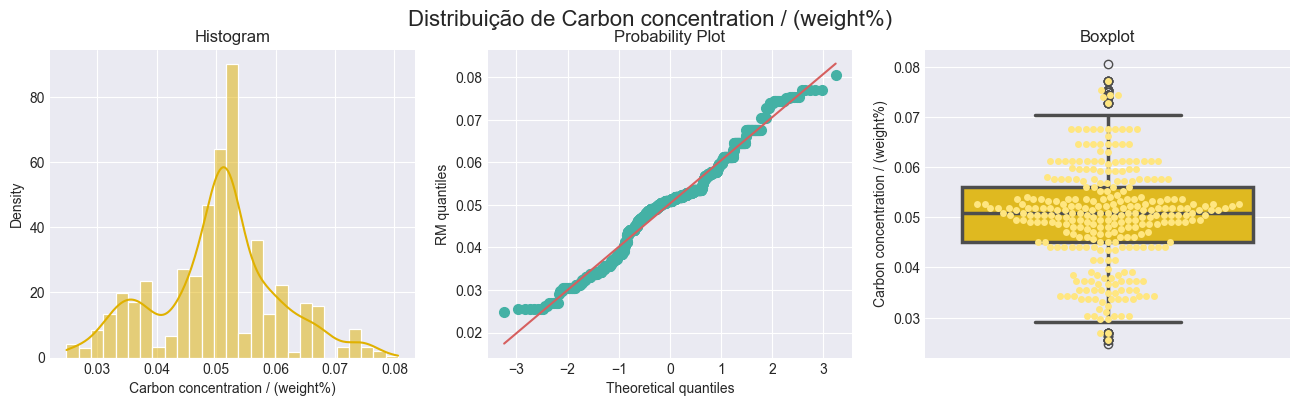

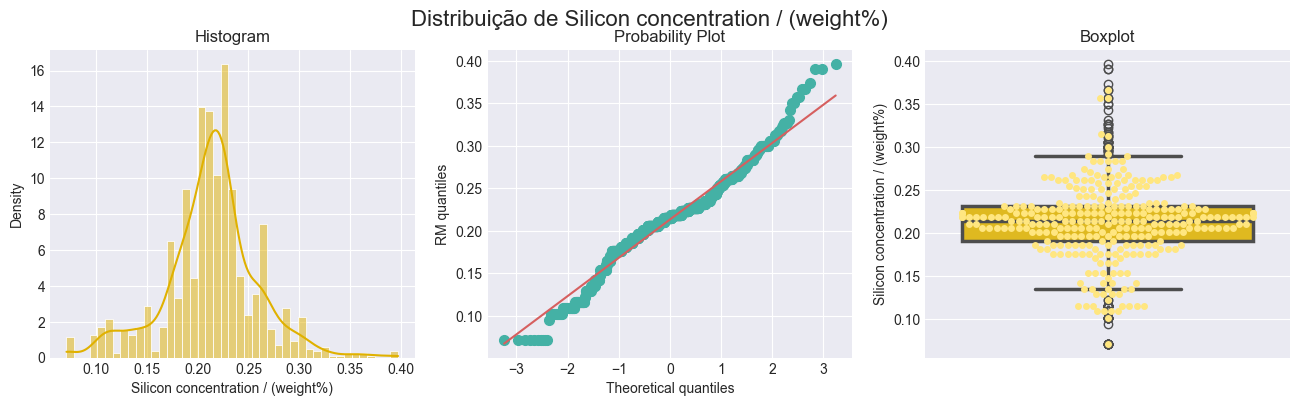

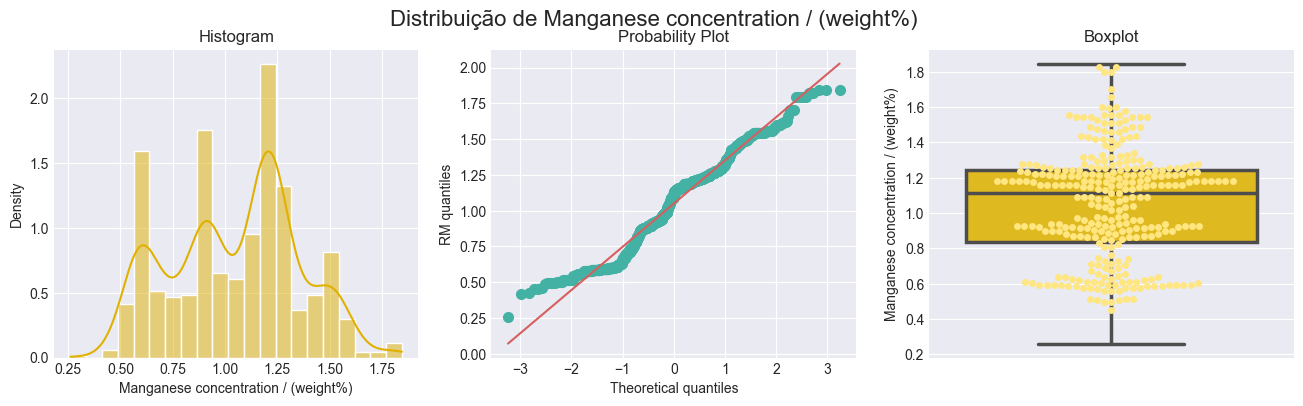

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



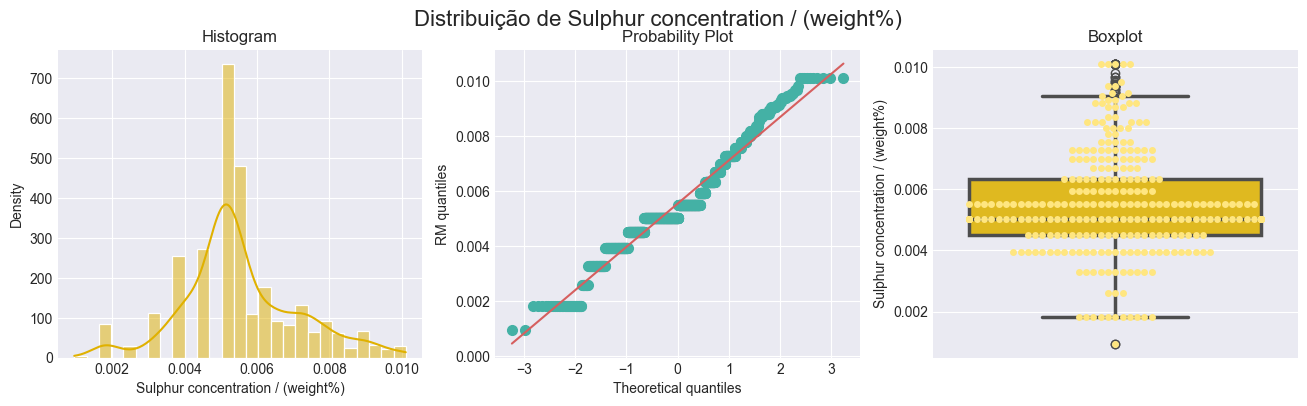

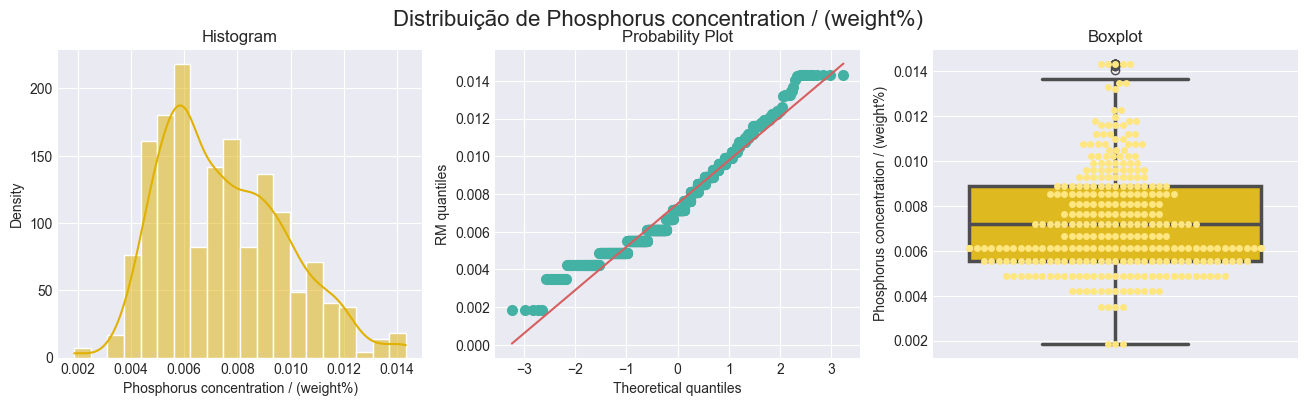

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



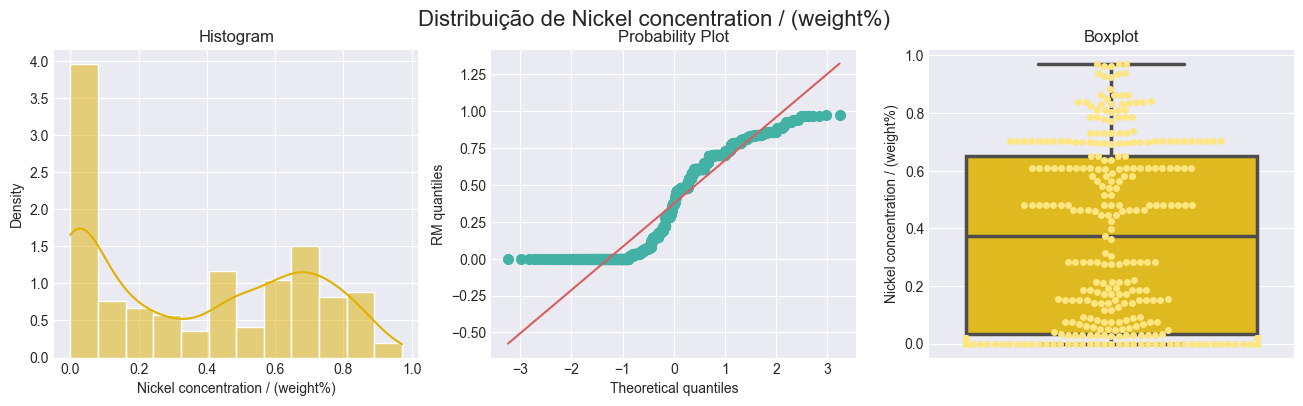

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



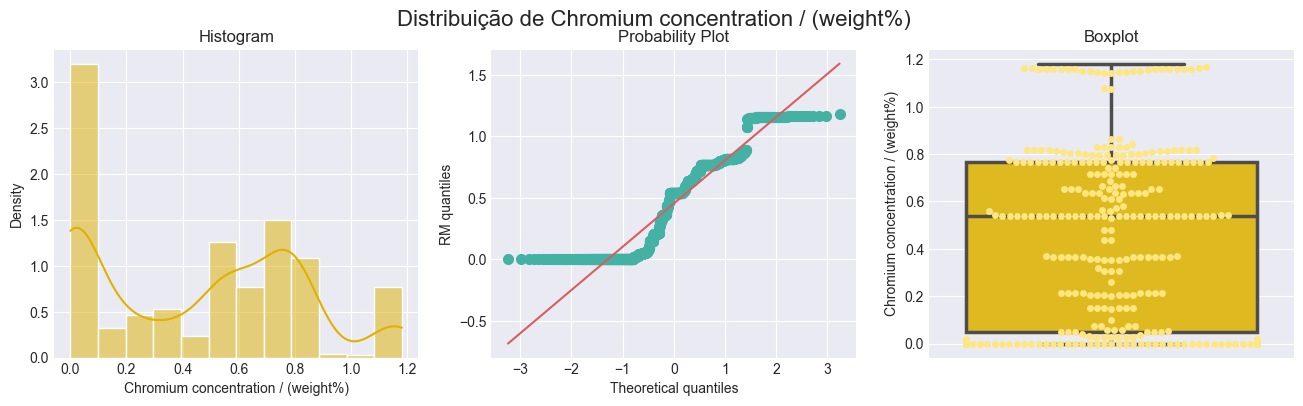

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

18.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



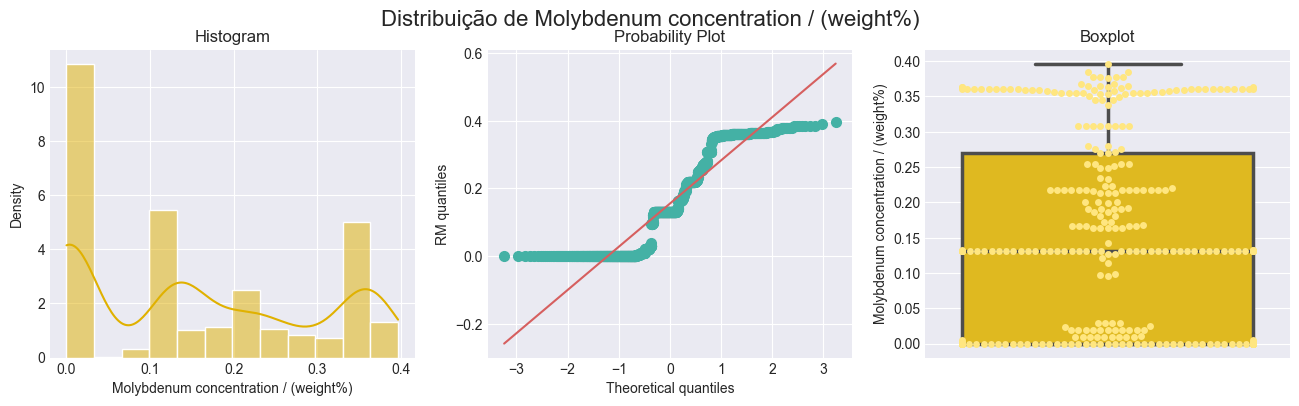

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

32.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

33.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



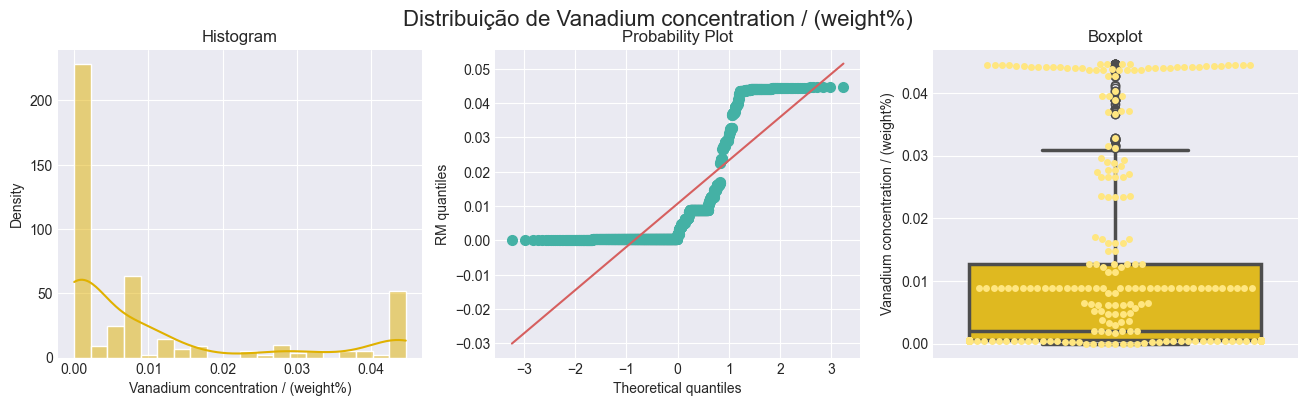

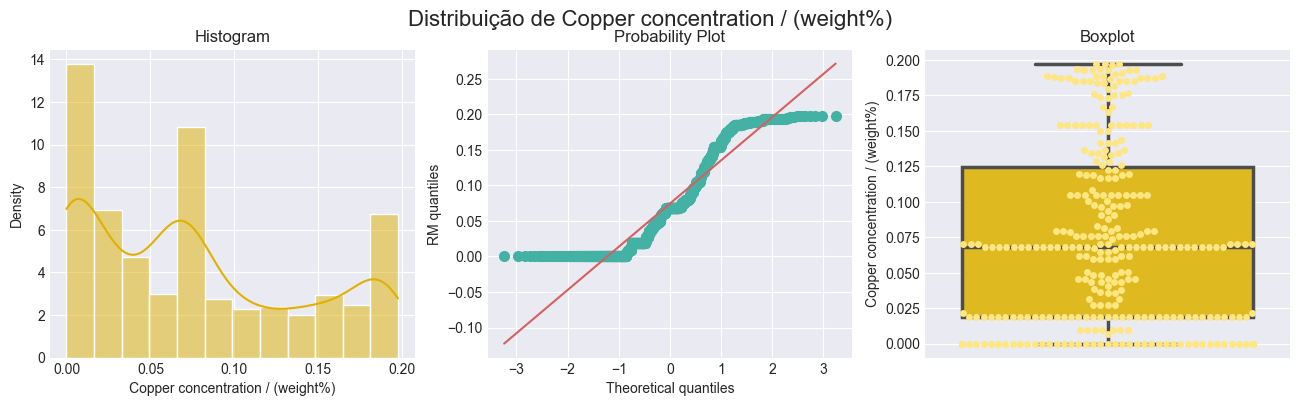

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

47.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

49.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



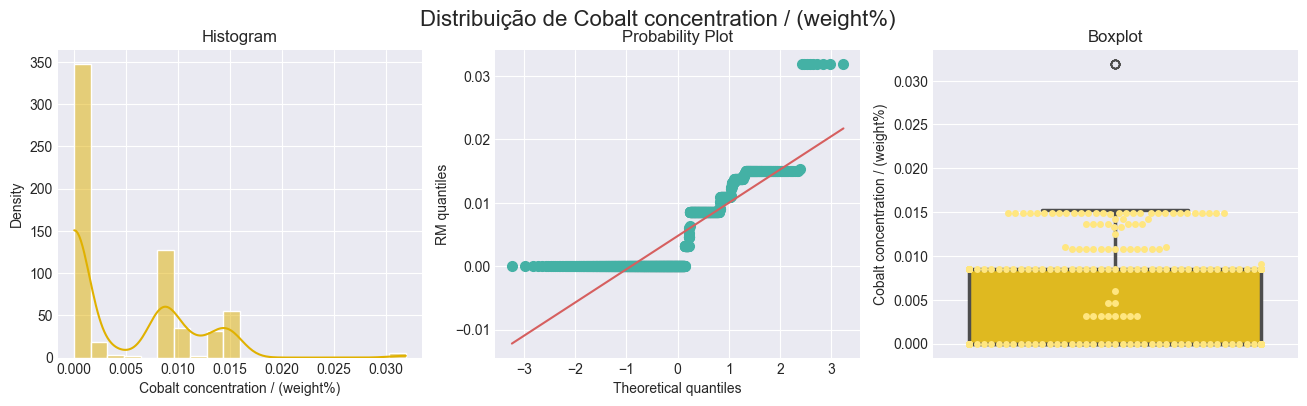

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

57.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

59.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



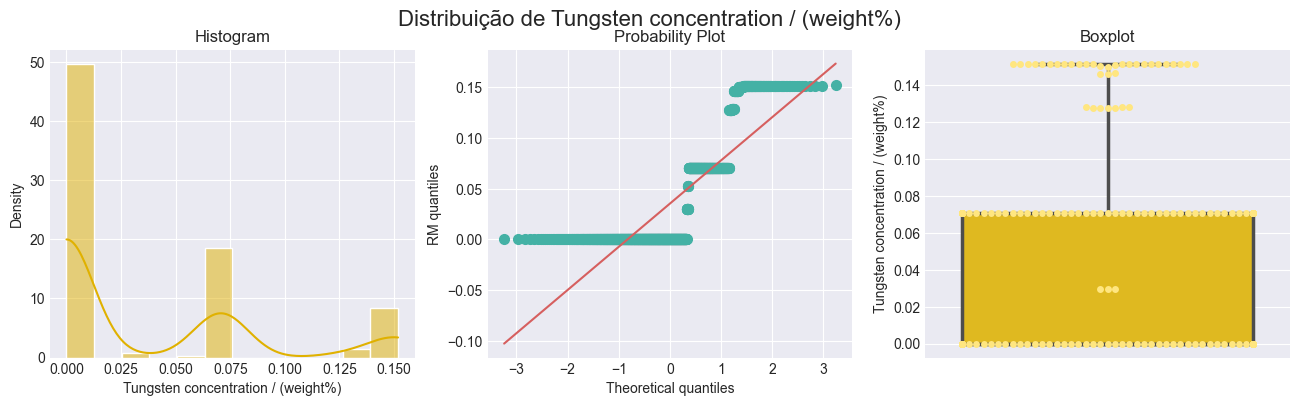

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

18.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



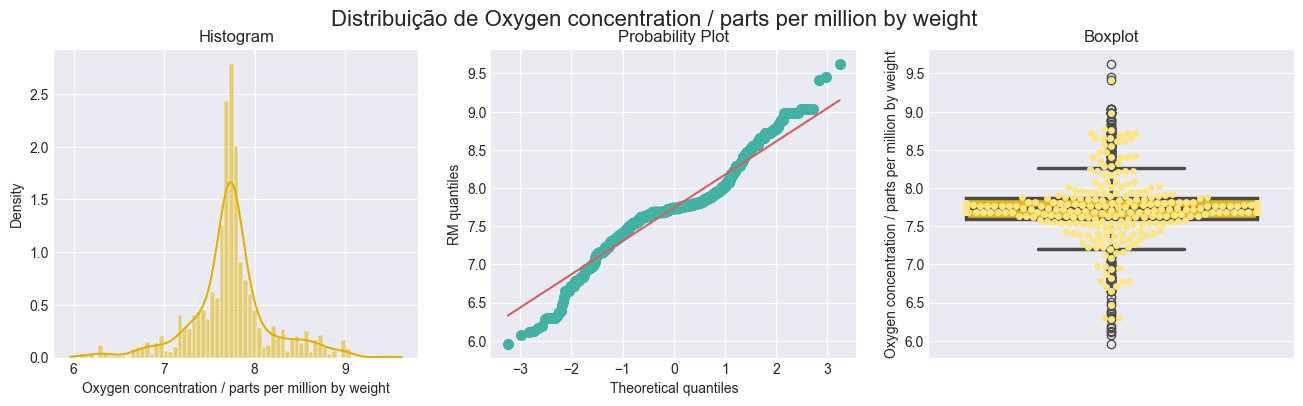

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



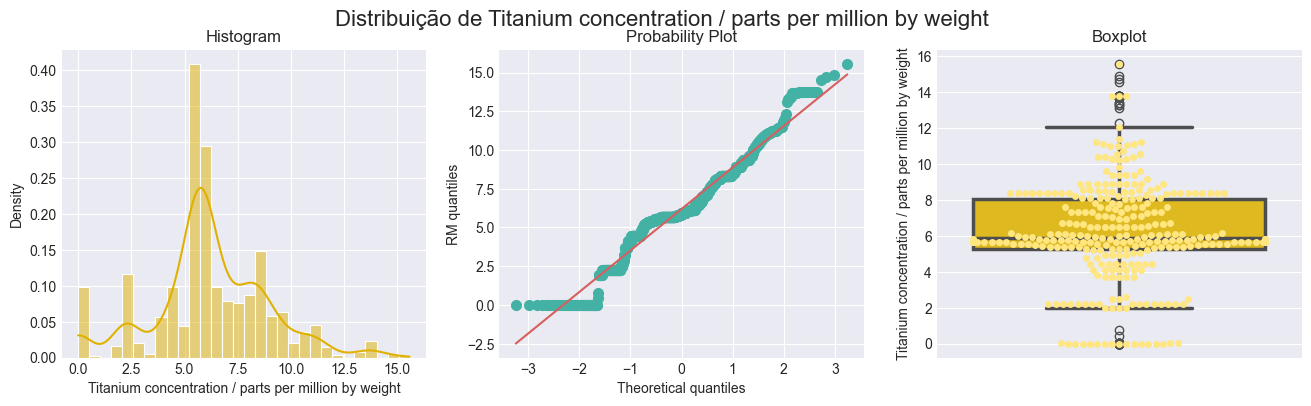

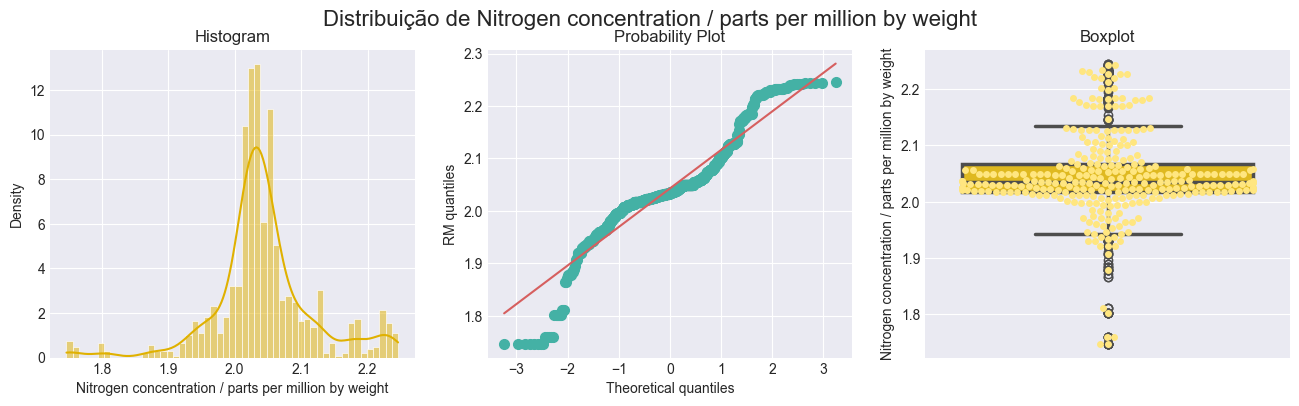

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



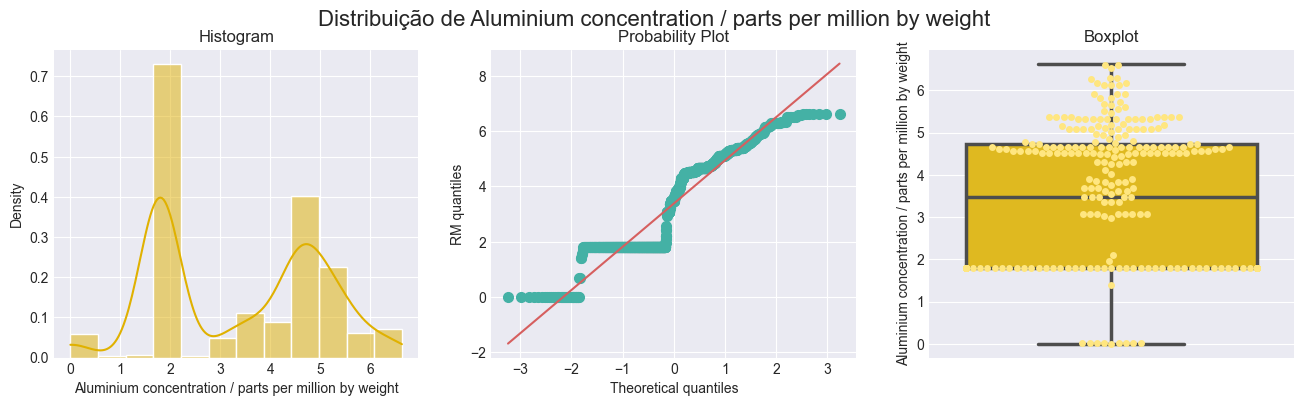

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

53.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

56.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



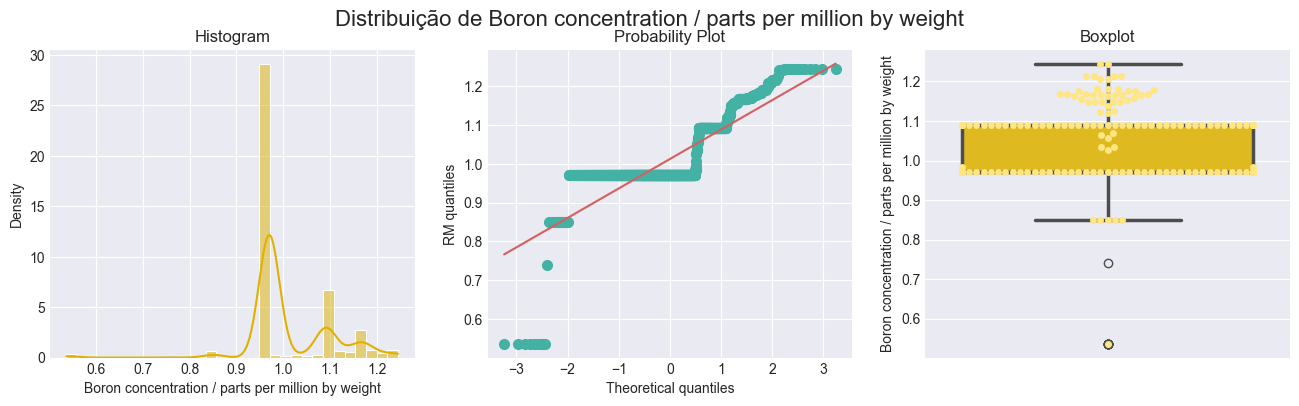

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



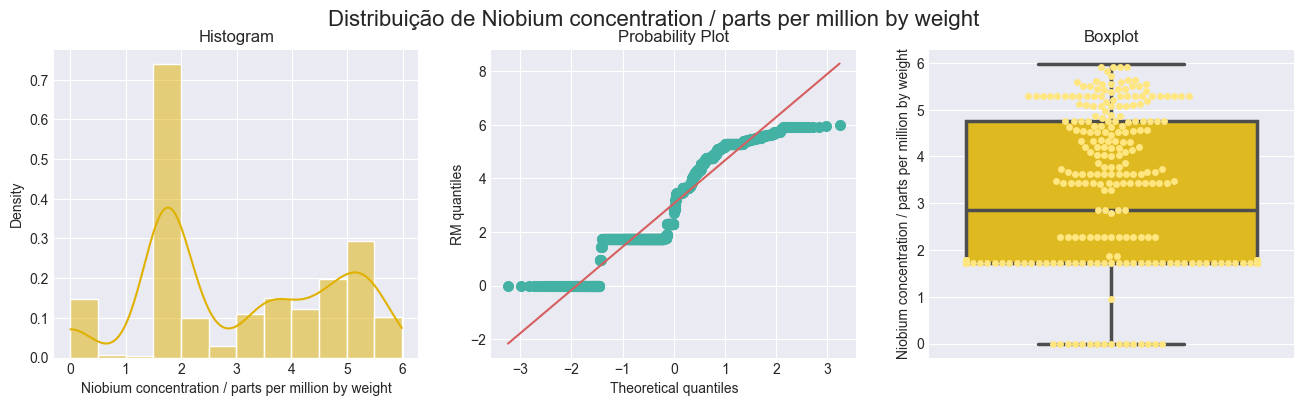

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

37.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

40.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



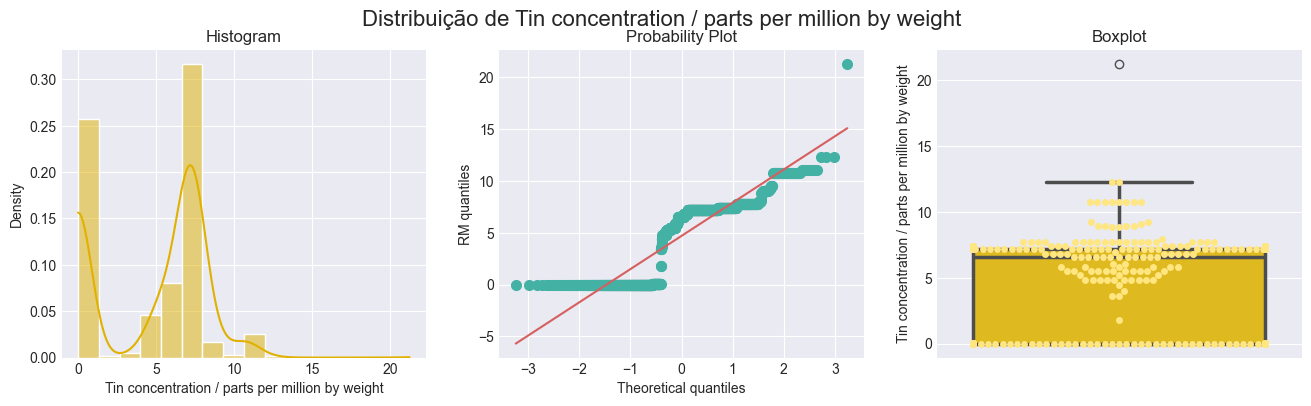

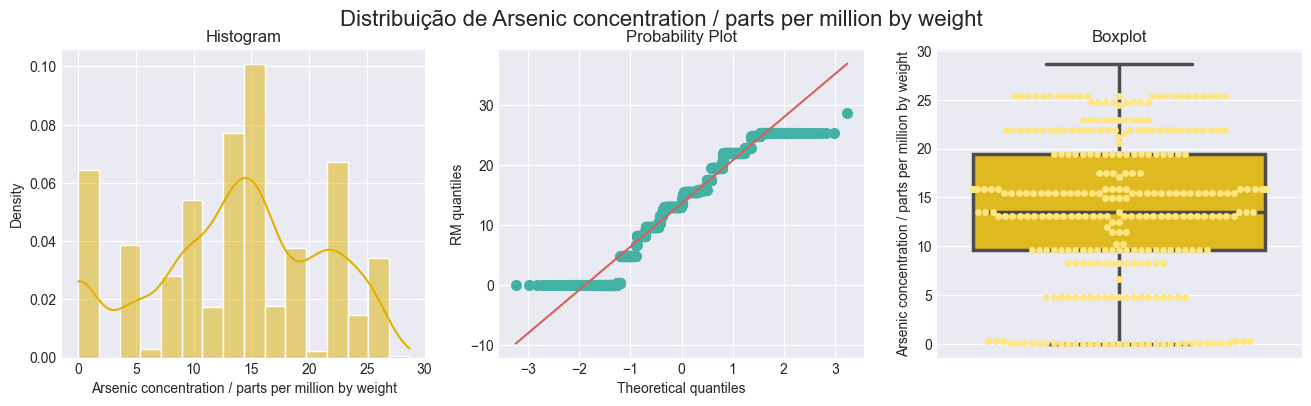

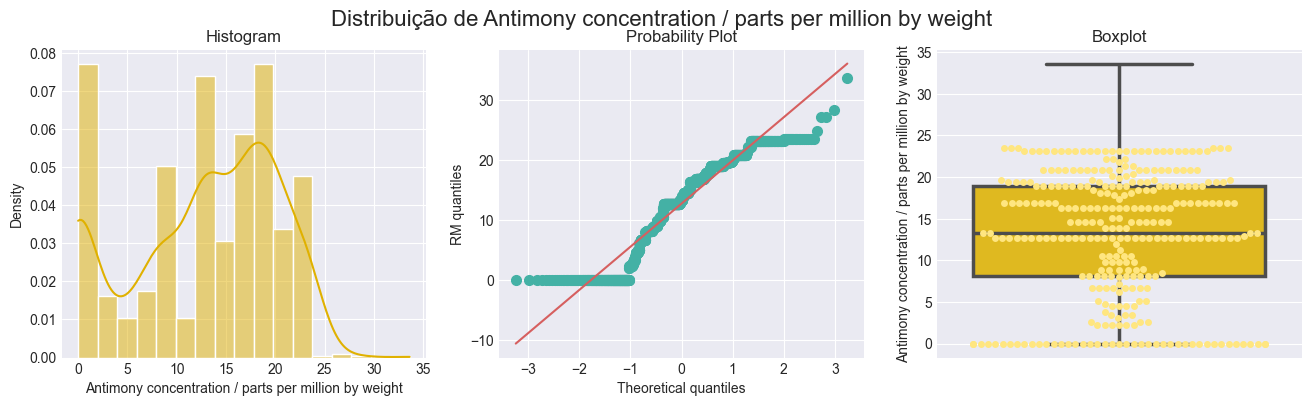

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

44.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

46.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



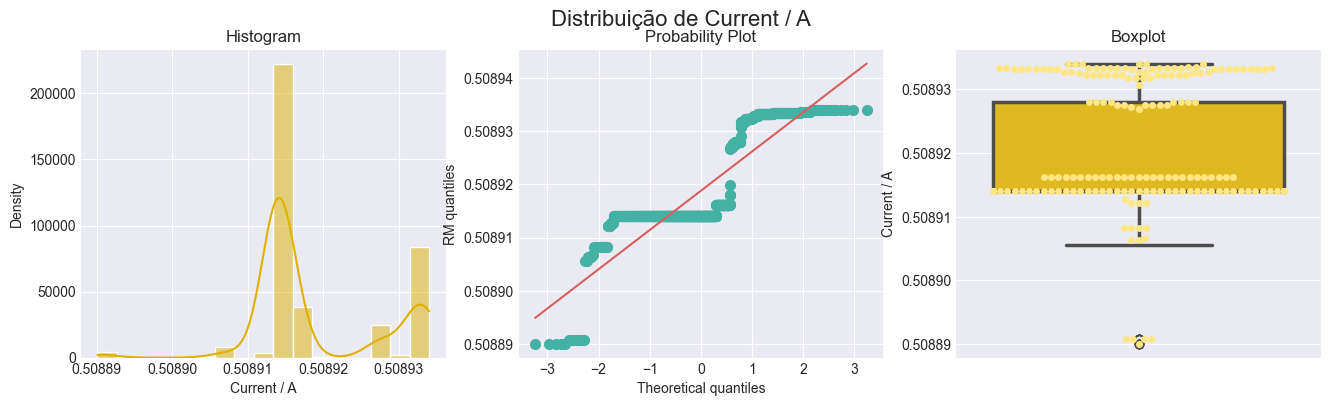

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

45.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



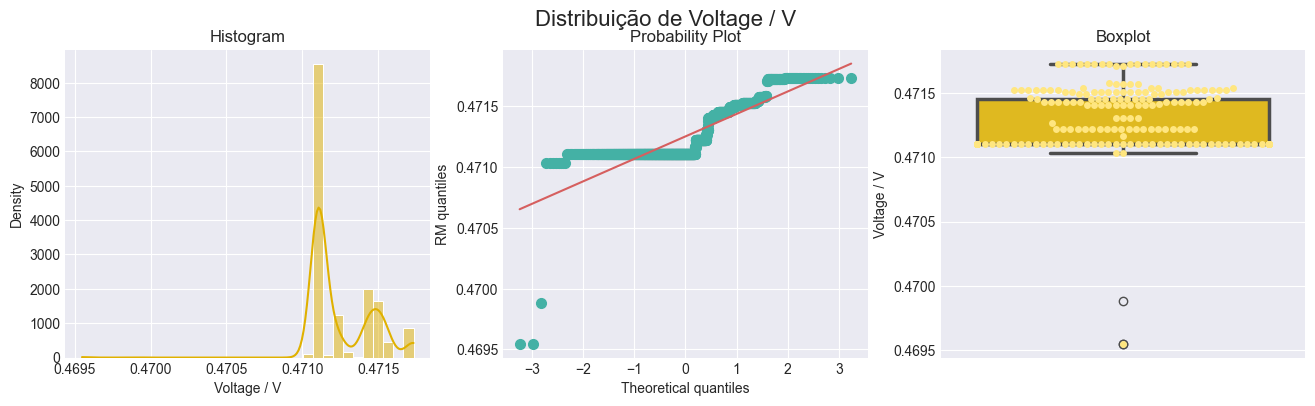

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

49.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

51.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



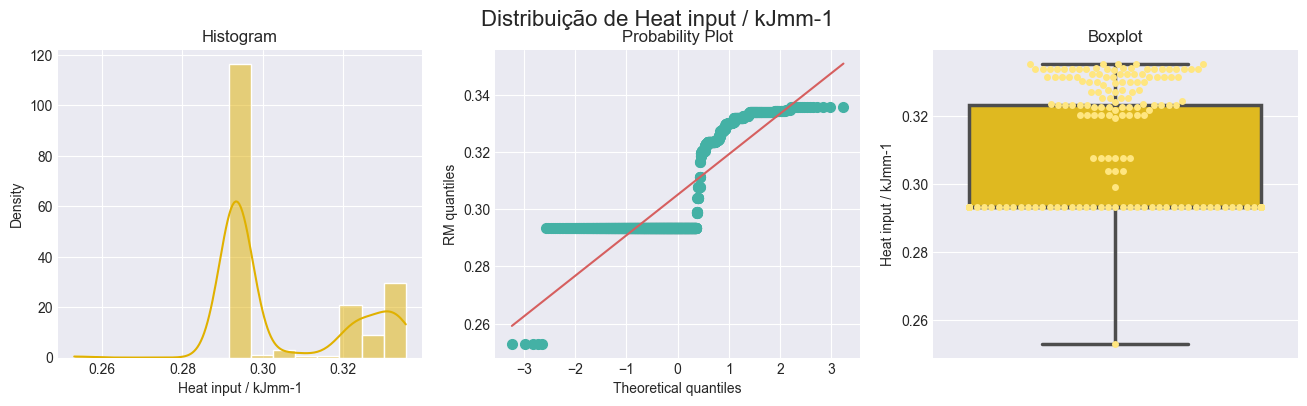

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

50.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

51.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



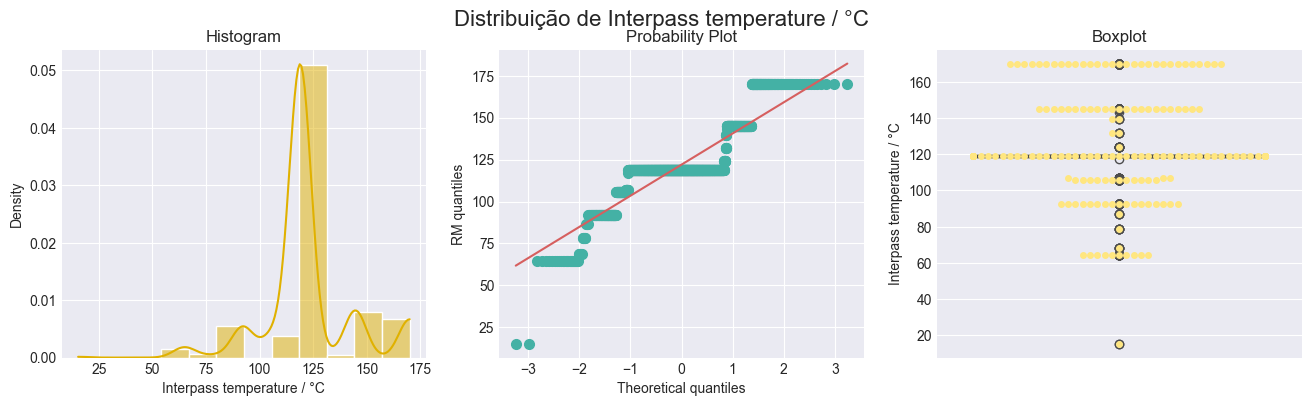

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

31.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



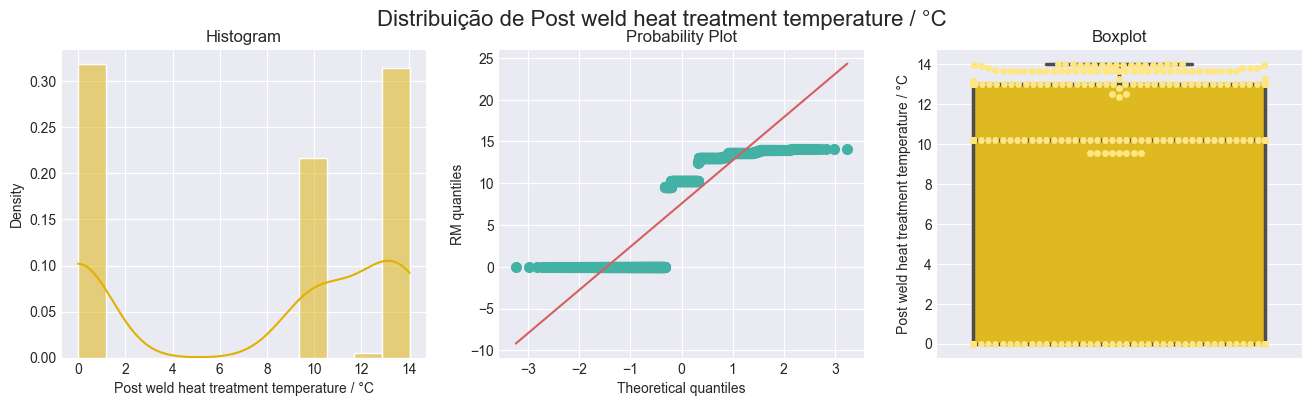

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

31.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



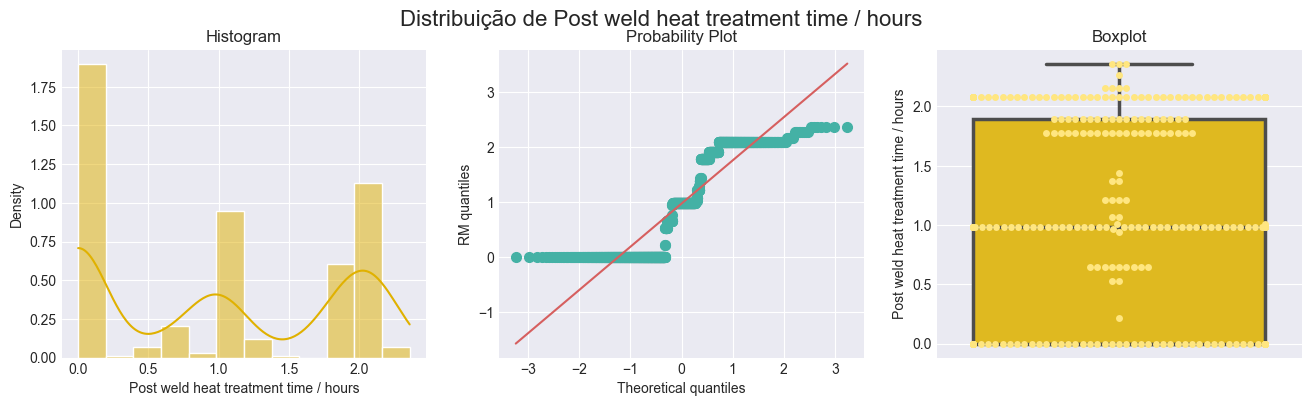

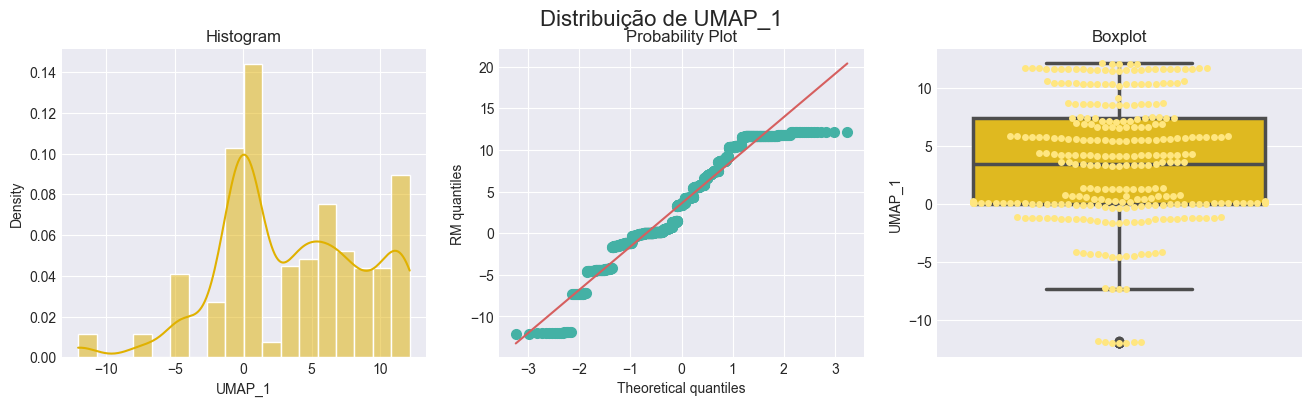

c:\Users\merte\miniconda3\lib\site-packages\seaborn\categorical.py:3399: UserWarning:

6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



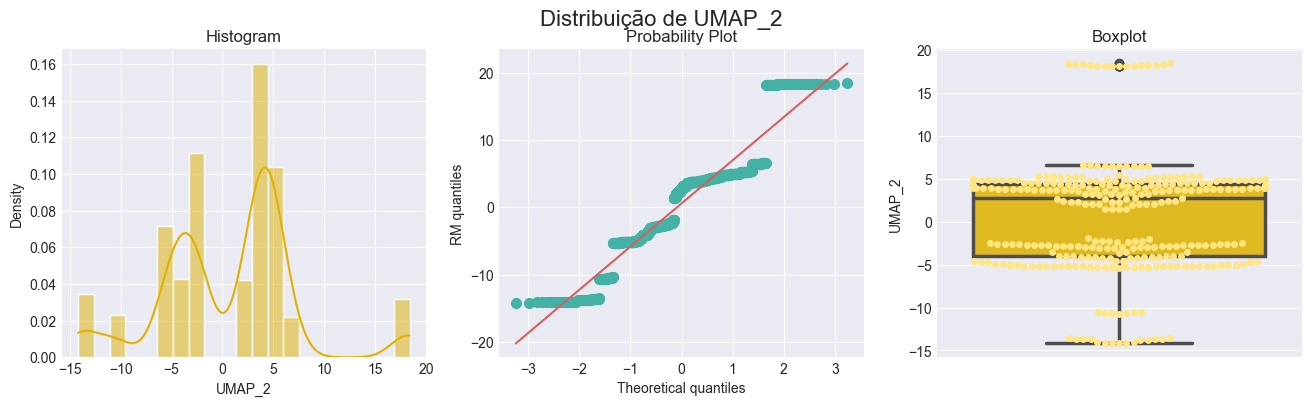

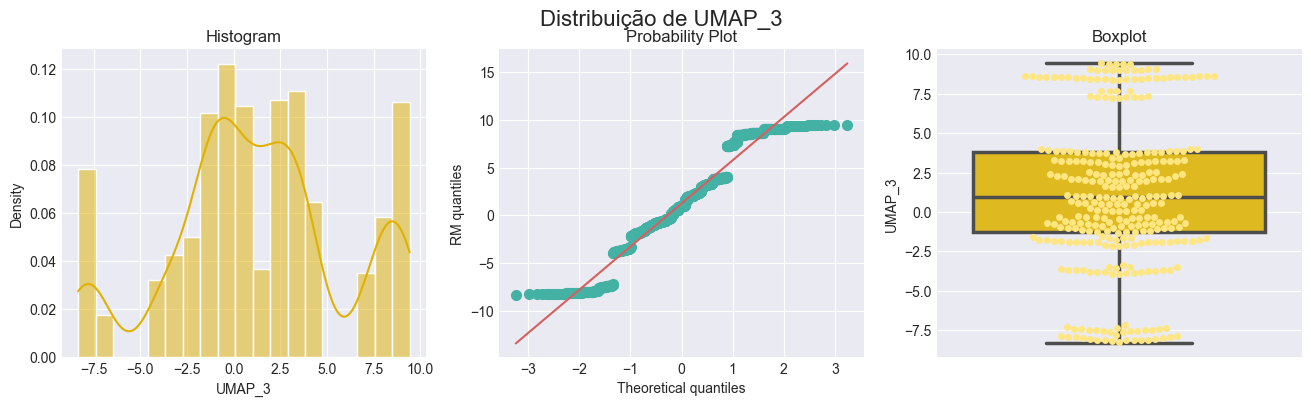

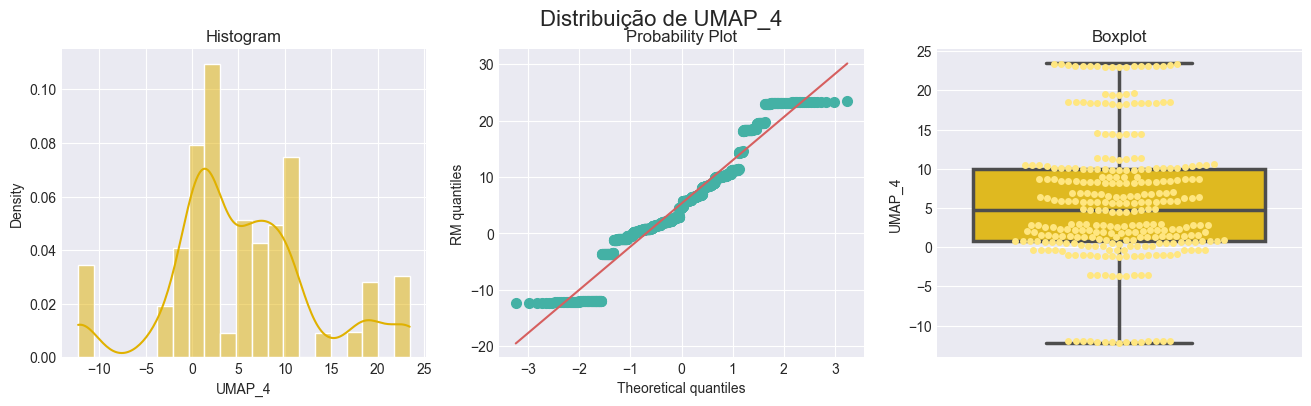

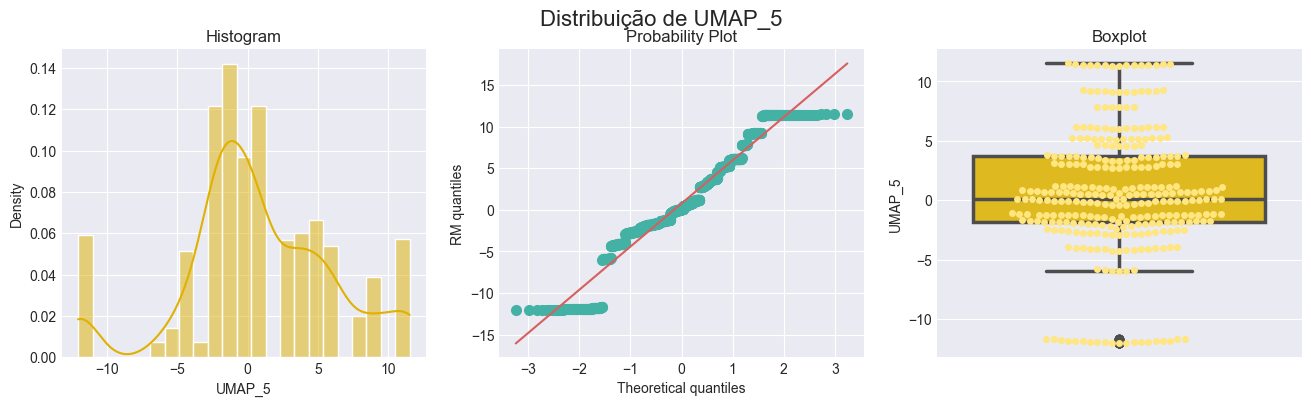

In [87]:
for feature in numeric_features:
  diagnostic_plots(X_train_knn,feature,'matplotlib')

## Outliers

We also noticed after the transformations that the variables still have outliers. However, treating these outliers may represent a loss of information. We will therefore choose not to treat these outliers, as removing them could mean a huge loss of information.

## Feature Scalling


As we prefer to keep the outliers in the previous section, we will then use the RobustScaler, which is robust to outliers.

To do this, let's visualize the Carbon concentration / (weight%) variable before the transformation:



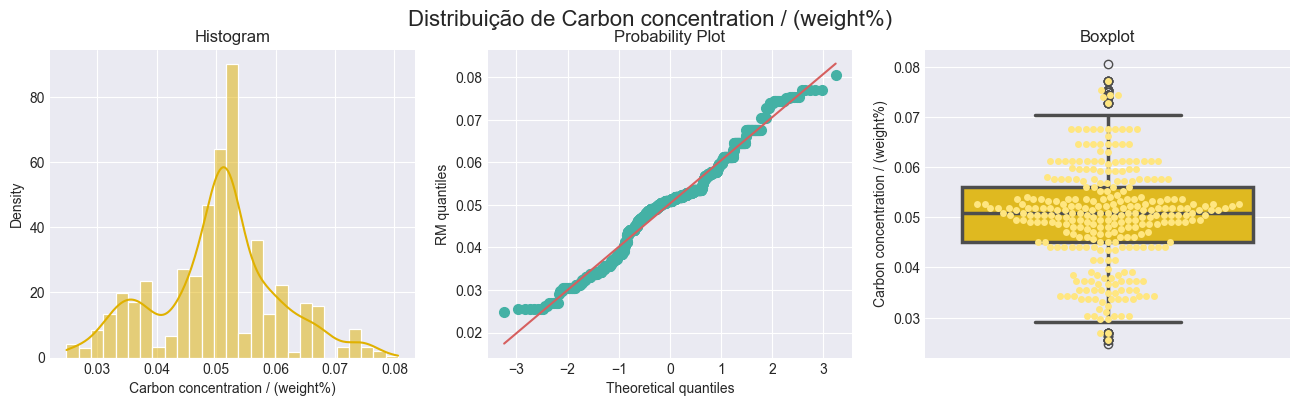

In [96]:
diagnostic_plots(X_train_knn,'Carbon concentration / (weight%)','matplotlib')


In [97]:
scaler=RobustScaler()

scaler.fit(X_train_knn)

X_train_knn=pd.DataFrame(scaler.transform(X_train_knn),columns=X_train_knn.columns,index=X_train_knn.index)
X_valid_knn=pd.DataFrame(scaler.transform(X_valid_knn),columns=X_valid_knn.columns,index=X_valid_knn.index)
X_test_knn=pd.DataFrame(scaler.transform(X_test_knn),columns=X_test_knn.columns,index=X_test_knn.index)

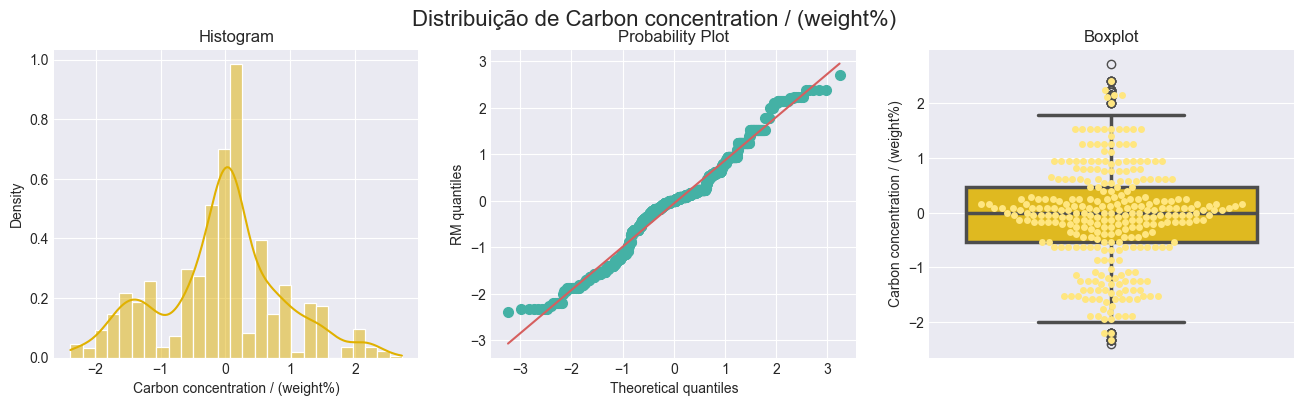

In [98]:
diagnostic_plots(X_train_knn,'Carbon concentration / (weight%)','matplotlib')

## Pre-feature selection:

Let's remove the variables that have equal values in more than 99% of the instances:

In [91]:
drop_const_feat = DropConstantFeatures(tol=0.99)
drop_const_feat.fit(X_train_knn)
drop_const_feat.features_to_drop_

['group_1']

In [92]:
X_train_knn=drop_const_feat.transform(X_train_knn)
X_valid_knn=drop_const_feat.transform(X_valid_knn)
X_test_knn=drop_const_feat.transform(X_test_knn)

## Duplicated Features


In [94]:
# set up the transformer
drop_dupl_feat = DropDuplicateFeatures()

# fit the transformer
drop_dupl_feat.fit(X_train_knn)

drop_dupl_feat.features_to_drop_

set()

In [95]:
X_train_knn=drop_dupl_feat.transform(X_train_knn)
X_valid_knn=drop_dupl_feat.transform(X_valid_knn)
X_test_knn=drop_dupl_feat.transform(X_test_knn)

## Saving the processed data

In [40]:
import os

def save_date(X_train, X_valid, X_test, name):
    yeojohnson_transform=vt.YeoJohnsonTransformer(variables=numeric_features)

    yeojohnson_transform.fit(X_train)

    X_train=yeojohnson_transform.transform(X_train)
    X_valid=yeojohnson_transform.transform(X_valid)
    X_test=yeojohnson_transform.transform(X_test)

    scaler=RobustScaler()

    scaler.fit(X_train)

    X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns,index=X_train.index)
    X_valid=pd.DataFrame(scaler.transform(X_valid),columns=X_valid.columns,index=X_valid.index)
    X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

    drop_const_feat = DropConstantFeatures(tol=0.99)
    drop_const_feat.fit(X_train)
    drop_const_feat.features_to_drop_

    X_train=drop_const_feat.transform(X_train)
    X_valid=drop_const_feat.transform(X_valid)
    X_test=drop_const_feat.transform(X_test)

    # set up the transformer
    drop_dupl_feat = DropDuplicateFeatures()

    # fit the transformer
    drop_dupl_feat.fit(X_train)

    drop_dupl_feat.features_to_drop_

    X_train=drop_dupl_feat.transform(X_train)
    X_valid=drop_dupl_feat.transform(X_valid)
    X_test=drop_dupl_feat.transform(X_test)

    if not os.path.exists(f'processed_data/{name}'):
        os.makedirs(f'processed_data/{name}')

    X_train.to_csv(f'processed_data/{name}/processed_train_{name}.csv',index=False)
    X_valid.to_csv(f'processed_data/{name}/processed_validation_{name}.csv',index=False)
    X_test.to_csv(f'processed_data/{name}/processed_test_{name}.csv',index=False)

In [41]:
save_date(X_train_constant, X_valid_constant, X_test_constant, "constant")
save_date(X_train_mean, X_valid_mean, X_test_mean, "mean")
save_date(X_train_median, X_valid_median, X_test_median, "median")
save_date(X_train_mode, X_valid_mode, X_test_mode, "mode")
save_date(X_train_multiple, X_valid_multiple, X_test_multiple, "multiple")
save_date(X_train_knn, X_valid_knn, X_test_knn, "knn")

## Next Steps...


Now that we've processed our data, we're ready to test various machine learning models and find the best mathematical relationship between the target variable and the explanatory variables.